In [1]:
import os
import numpy as np
import pycolmap
import matplotlib.pyplot as plt
from matplotlib.image import imread

from megadepth.utils.read_write_dense import read_array

reconstruction = pycolmap.Reconstruction("../data/03_dense_model/south-building/0/sparse")

dense_dir = os.path.join("..", "data", "03_dense_model", "south-building", "0")

images = reconstruction.images
cameras = reconstruction.cameras
point3D = reconstruction.points3D

In [2]:
id_1 = 26

camera = cameras[images[id_1].camera_id]
image = images[id_1]

depth = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{image.name}.geometric.bin"))
colors = imread(os.path.join(dense_dir, "images", image.name))

In [3]:
# get 2D coordinates of all pixels
xy = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))
xy = np.stack([xy[0].flatten(), xy[1].flatten()], axis=1)

# subsample points
xy = xy[::10]
depth = depth.flatten()[::10]
colors = colors.reshape(-1, 3)[::10]

# project points from image to world coordinates
p_world = camera.image_to_world(xy)
p_world = np.array(p_world)

# project world points to 3D space
p3d = np.stack([p_world[:, 0], p_world[:, 1], depth], axis=1)

# filter points with invalid depth
colors = colors[p3d[:, 2] != 0]
p3d = p3d[p3d[:, 2] != 0]

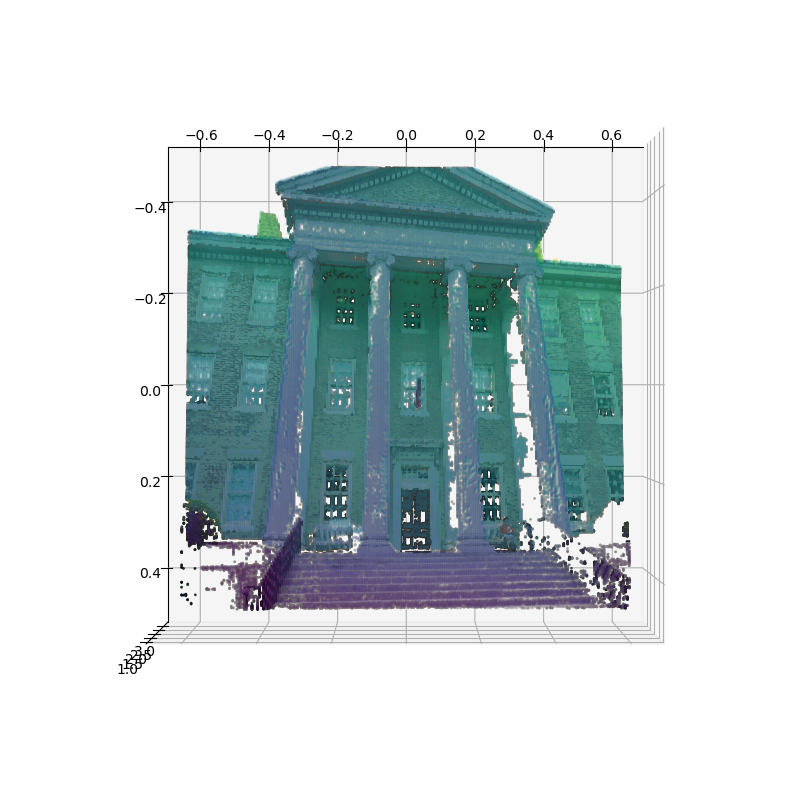

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

ax.scatter(p3d[:, 0], p3d[:, 1], p3d[:, 2], s=1, c=colors/255)
ax.scatter(p3d[:, 0], p3d[:, 1], p3d[:, 2], s=1, c=p3d[:, 2]/p3d[:, 2].max(), alpha=0.05)

ax.view_init(-90, -90)

plt.show()    

In [5]:
# project 3D points to image space
uv = camera.world_to_image(image.project(p3d))